In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from skimage.data import brick

import sys
sys.path.append("..")
import masks
import data

c:\Users\konie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# Figure 2

In [2]:
clean_img = brick()
clean_img = (clean_img - np.min(clean_img)) / (np.max(clean_img) - np.min(clean_img))
noise = 0.2*np.random.normal(size=clean_img.shape)
noisy_img = clean_img + noise

lw = 3
x = 100
y = 100
ps = 64

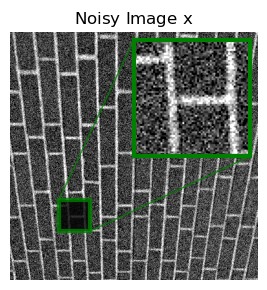

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(noisy_img, cmap='gray', origin="lower", vmin=0, vmax=1)
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x, x+ps), ylim=(y, y+ps), xticks=[], yticks=[])
axins.imshow(noisy_img, cmap='gray', origin="lower", vmin=0, vmax=1)
ax.axis('off')
ax.indicate_inset_zoom(axins, lw=lw, facecolor='black', edgecolor="green", alpha=0.8)
plt.setp(axins.spines.values(), lw=lw, color="green")
plt.title(r"Noisy Image $\mathrm{x}$")
plt.tight_layout()
plt.savefig('./out/figure_02_1.pdf', bbox_inches='tight')
plt.show()

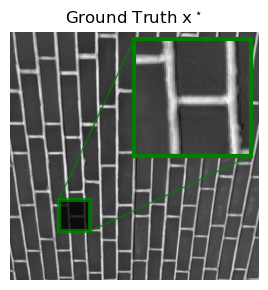

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(clean_img, cmap='gray', origin="lower", vmin=0, vmax=1)
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x, x+ps), ylim=(y, y+ps), xticks=[], yticks=[])
axins.imshow(clean_img, cmap='gray', origin="lower", vmin=0, vmax=1)
ax.axis('off')
ax.indicate_inset_zoom(axins, lw=lw, facecolor='black', edgecolor="green", alpha=0.8)
plt.setp(axins.spines.values(), lw=lw, color="green")
plt.title(r"Ground Truth $\mathrm{x}^\star$")
plt.tight_layout()
plt.savefig('./out/figure_02_2.pdf', bbox_inches='tight')
plt.show()

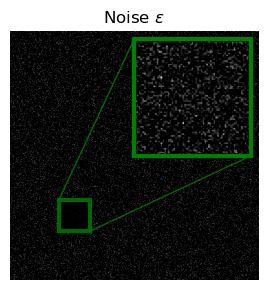

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(noise, cmap='gray', origin="lower", vmin=0, vmax=1)
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x, x+ps), ylim=(y, y+ps), xticks=[], yticks=[])
axins.imshow(noise, cmap='gray', origin="lower", vmin=0, vmax=1)
ax.axis('off')
ax.indicate_inset_zoom(axins, lw=lw, facecolor='black', edgecolor="green", alpha=0.8)
plt.setp(axins.spines.values(), lw=lw, color="green")
plt.title(r"Noise $\varepsilon$")
plt.tight_layout()
plt.savefig('./out/figure_02_3.pdf', bbox_inches='tight')
plt.show()

# Figure 3

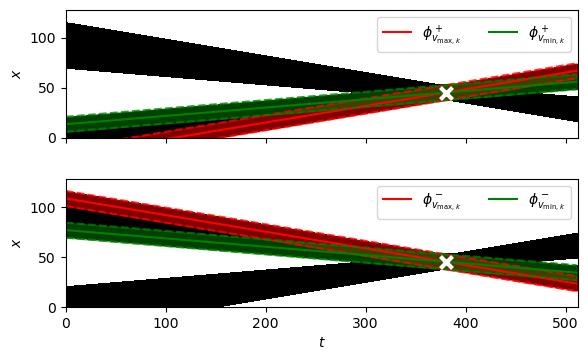

In [6]:
dx = 4
fs = 50

B = 1
nx = 128
nt = 512
x = torch.randn((B,1,nx,nt))
center = torch.tensor([[ 45,  380]])

nx_width = 16

mask, center_mask = masks.xmask(x, center, nx_width=nx_width, dx=dx)
off1, off2, toff1, toff2 = masks.get_offsets(nx_width, dx=dx)
off = (nx_width - 1) / 2

m_u, m_l = masks.get_slopes(dx, fs)

idx = 0
c1 = center[idx,1].item()
c2 = center[idx,0].item()

# plot traffic colored area
t = np.arange(nt)
ft = lambda m: m * (t - c1) + c2

lw = 4
a_bg = 0.5
a_b = 0.75

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(6,4))
for i, s in enumerate([1,-1]):
    axs[i].imshow((mask)[idx,0], cmap='gray', origin='lower', interpolation='none', aspect='equal', alpha=1)
    
    axs[i].plot(t, ft(s*m_u), color='r', label=r'$\phi_{v_{\max,k}}^+$' if s==1 else r'$\phi_{v_{\max,k}}^-$')
    axs[i].plot(t, ft(s*m_u) + off, color='r', linestyle='--', alpha=a_b)              # 1
    axs[i].plot(t, ft(s*m_u) - off, color='r', linestyle='--', alpha=a_b)              # 2
    axs[i].fill_between(t, ft(s*m_u) + off, ft(s*m_u) - off, alpha=a_bg, color='r')    # 1 2
    axs[i].plot(t, ft(s*m_l), color='g', label=r'$\phi_{v_{\min,k}}^+$' if s==1 else r'$\phi_{v_{\min,k}}^-$')
    axs[i].plot(t, ft(s*m_l) + off, color='g', linestyle='--', alpha=a_b)              # 2
    axs[i].plot(t, ft(s*m_l) - off, color='g', linestyle='--', alpha=a_b)              # 1
    axs[i].fill_between(t, ft(s*m_l) + off, ft(s*m_l) - off, alpha=a_bg, color='g')    # 2 1
    
    axs[i].scatter(c1, c2, marker='x', c='w', linewidth=3, s=75, zorder=2)
    axs[i].set_xlim(0,nt)
    axs[i].set_ylim(0,nx)
    axs[i].legend(loc=1, ncols=2)

axs[0].set_ylabel(r'$x$')
axs[1].set_ylabel(r'$x$')
axs[1].set_xlabel(r'$t$')
plt.tight_layout()
plt.savefig('./out/figure_03.pdf', bbox_inches='tight')
plt.show()

# Figure 4

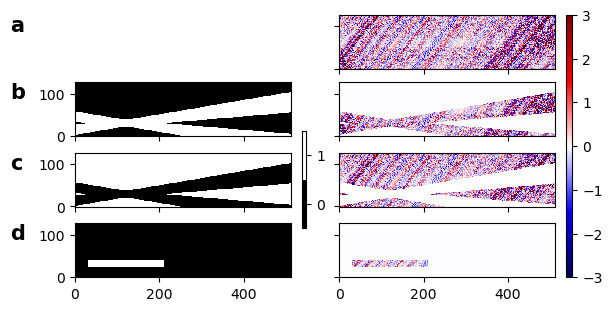

In [7]:
dx = 4
fs = 50

B = 2
nx = 128
nt = 512

samples_per_epoch = 10_000

seed = 22222
np.random.seed(seed)
torch.manual_seed(seed)

eq_train = torch.from_numpy(np.load('../data/preprocessed/SIS-rotated_train_50Hz.npy'))
traffic_inc_train = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_train_50Hz_{:02d}_inc.npy'.format(i)) for i in range(5)]))
traffic_dec_train = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_train_50Hz_{:02d}_dec.npy'.format(i)) for i in range(5,12)]))
eq_train /= eq_train.std(dim=-1, keepdim=True)
traffic_inc_train /= traffic_inc_train.std(dim=-1, keepdim=True)
traffic_dec_train /= traffic_dec_train.std(dim=-1, keepdim=True)

eq_test = torch.from_numpy(np.load('../data/preprocessed/SIS-rotated_test_50Hz.npy'))
traffic_inc_test = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_test_50Hz_{:02d}_inc.npy'.format(i)) for i in range(4)]))
traffic_dec_test = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_test_50Hz_{:02d}_dec.npy'.format(i)) for i in range(4,8)]))
eq_test /= eq_test.std(dim=-1, keepdim=True)
traffic_inc_test /= traffic_inc_test.std(dim=-1, keepdim=True)
traffic_dec_test /= traffic_dec_test.std(dim=-1, keepdim=True)

trainset = data.SyntheticTrafficDAS(eq_train, 
                                    traffic_inc_train, traffic_dec_train,
                                    nx=nx, nt=nt, eq_slowness=(1e-4, 5e-3), traffic_slowness=(3e-2, 6e-2),
                                    dx=dx, fs=fs, size=samples_per_epoch)
testset = data.SyntheticTrafficDAS(eq_test, 
                                   traffic_inc_test, traffic_dec_test,
                                   nx=nx, nt=nt, eq_slowness=(1e-4, 5e-3), traffic_slowness=(3e-2, 6e-2),
                                   dx=dx, fs=fs, size=samples_per_epoch//10)

batch_size = 32
dloader = {'train': DataLoader(trainset, batch_size=batch_size, shuffle=True), 
           'test': DataLoader(testset, batch_size=batch_size, shuffle=False)}

x, eq, traffic, scale, amp = next(iter(dloader['test']))
center = torch.cat([torch.randint(0, nx, (batch_size,1)),
                    torch.randint(0, nt, (batch_size,1))], dim=1)
idx = 1
center[idx] = torch.tensor([30,120])

nx_width = 16

input_mask, center_mask = masks.xmask(x, center, nx_width=nx_width)
off1, off2, toff1, toff2 = masks.get_offsets(nx_width)
off = (nx_width - 1) / 2

m_u, m_l = masks.get_slopes(dx, fs)

c1 = center[idx,1].item()
c2 = center[idx,0].item()

# plot traffic colored area
t = np.arange(nt)
ft = lambda m: m * (t - c1) + c2

lw = 4
a_bg = 0.5
a_b = 0.75
v = 3

cmap1 = plt.get_cmap('gray', 2)
cmap2 = 'seismic'

mu = torch.sum(input_mask * x, dim=-2, keepdim=True) / torch.sum(input_mask, dim=-2, keepdim=True)
x_in = input_mask * x 

fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(9,3), layout='compressed')

axs[0,1].imshow(x[idx,0], cmap=cmap2, origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)

axs[1,0].imshow((1-input_mask)[idx,0], cmap=cmap1, origin='lower', interpolation='none', aspect='equal', vmin=-0.5, vmax=1.5)
axs[1,1].imshow((x*(1-input_mask))[idx,0], cmap=cmap2, origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)

axs[2,0].imshow((input_mask)[idx,0], cmap=cmap1, origin='lower', interpolation='none', aspect='equal', vmin=-0.5, vmax=1.5)
axs[2,1].imshow((x_in)[idx,0], cmap=cmap2, origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)
im = axs[3,0].imshow((center_mask)[idx,0], cmap=cmap1, origin='lower', interpolation='none', aspect='equal', vmin=-0.5, vmax=1.5)
fig.colorbar(im, ax=axs[1:,0], ticks=[0,1], location='right', shrink=0.5, aspect=20, pad=0.05)
im = axs[3,1].imshow(((amp[:,None,None,None]*eq/scale)*(center_mask))[idx,0], cmap=cmap2, origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)
fig.colorbar(im, ax=axs[:,1], location='right', shrink=1, aspect=40, pad=0.05)

axs[0,0].axis('off')

axs[0,0].text(-0.3, 0.7, 'a', transform=axs[0,0].transAxes, size=15, weight='bold')
axs[1,0].text(-0.3, 0.7, 'b', transform=axs[1,0].transAxes, size=15, weight='bold')
axs[2,0].text(-0.3, 0.7, 'c', transform=axs[2,0].transAxes, size=15, weight='bold')
axs[3,0].text(-0.3, 0.7, 'd', transform=axs[3,0].transAxes, size=15, weight='bold')

plt.savefig('./out/figure_04.pdf', bbox_inches='tight')
plt.show()

# Figure 5

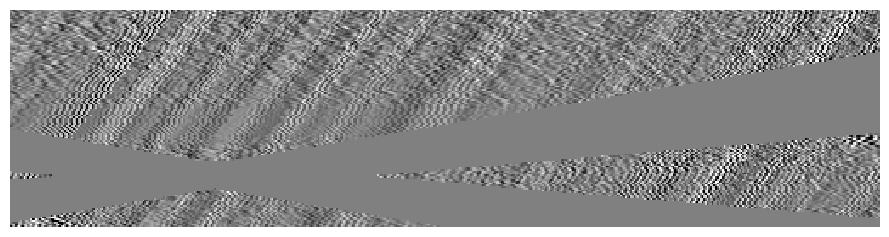

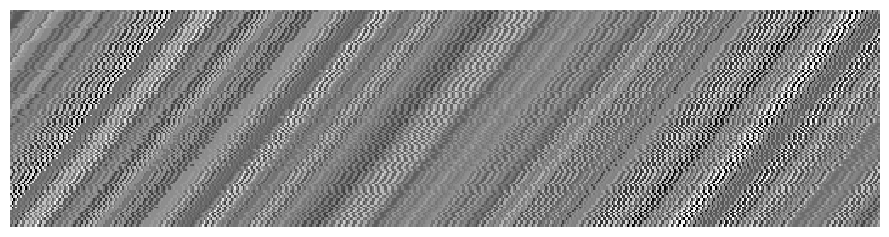

In [8]:
idx = 1

fig, ax = plt.subplots(1, 1, figsize=(9,3))
ax.imshow((x_in)[idx,0], cmap='gray', origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)
ax.axis('off')

plt.tight_layout()
plt.savefig('./out/figure_05_1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(9,3))
ax.imshow((eq)[idx,0], cmap='gray', origin='lower', interpolation='none', aspect='equal', vmin=-v, vmax=v)
ax.axis('off')

plt.tight_layout()
plt.savefig('./out/figure_05_2.pdf', bbox_inches='tight')
plt.show()